this script plots countries' contribution to science

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [70]:
cntry_fund_path='../../data/NationalFunding/Data/DerivedData/Derived/cntry_fund_frac.csv'
pubs_path="../../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"
flag_path='../../data/NationalFunding/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'
region_path="../../data/NationalFunding/Data/AdditionalData/cntry_region.xlsx"

cntry_funding_path='../../data/NationalFunding/Figs/cntry_funding_absolute_fraction_number.pdf'
cntry_funding_pubcnt_path='../../data/NationalFunding/Figs/cntry_funding_absolute_pub_number.pdf'

In [71]:
cntry_fund=pd.read_csv(cntry_fund_path)
cntry_fund=cntry_fund[cntry_fund.funder!='Not-Funded']
cntry_fund.head()

,funder,year,intcol,cnt
0,Afghanistan,2010,1,1.000000
1,Afghanistan,2011,1,0.333333
2,Afghanistan,2012,1,0.333333
3,Afghanistan,2015,0,0.148352
4,Afghanistan,2015,1,0.279167


In [72]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [73]:
flag_df=pd.read_csv(flag_path, sep='\t')[['WoS','Code']]
flag_df.head()

,WoS,Code
0,Albania,ALB
1,Algeria,DZA
2,Angola,AGO
3,Argentina,ARG
4,Australia,AUS


In [74]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']]
region=region.rename(columns={'region2':'region'})
region.head()

,cntry,region
0,Algeria,Africa
1,Angola,Africa
2,Belgian Congo,Africa
3,Benin,Africa
4,Botswana,Africa


calculate the number of funded publication each year

normalize country's to proportion

In [75]:
def get_absolute(data,collsig):
    data=data[data.intcol>=collsig]#to decide whethere include no-international collaboration or not
    cntry_ratio=data.groupby(['funder','year'])['cnt'].sum().reset_index()
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='funder',values='cnt',fill_value=0)
    return cntry_ratio

In [76]:
n=10
topn=cntry_fund.groupby('funder')[
    'cnt'].sum().sort_values(ascending=False).head(n).index.values


get the contribution of top 10 countries

In [77]:
cntry_ratio=get_absolute(cntry_fund,0)
topn_df=cntry_ratio[topn].reset_index()
topn_df=topn_df.melt(id_vars='year')  
topn_df=topn_df.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the contribution to international collaboration of top 10 countries

In [78]:
cntrycoll_ratio=get_absolute(cntry_fund,1)
topn_coll=cntrycoll_ratio[topn].reset_index()
topn_coll=topn_coll.melt(id_vars='year') 
topn_coll=topn_coll.merge(flag_df,left_on='funder',right_on='WoS',how='left')

In [79]:
clist=['#A6341B','#F2506E']+['#D0D2F2']*8
def plot(data,ax,texty,text):
    sns.lineplot(x='year',y='value',hue='funder',data=data,legend=False,
                 ax=ax,hue_order=topn,palette=clist,marker='o',linewidth=1,markersize=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

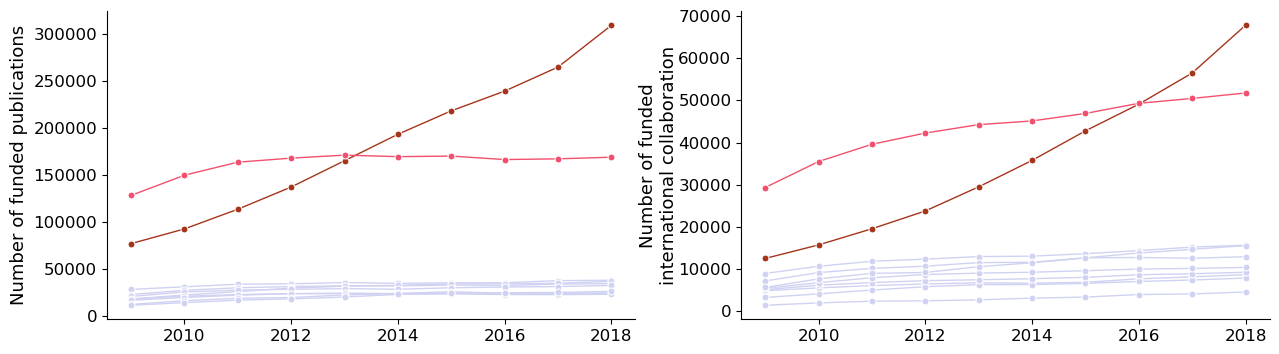

In [80]:
#{'#F2CB05':yellow,'#88C9F2':blue,'#C5C9C7':gray,'#F74F5A'}
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
ax0=ax[0]
ax1=ax[1]


texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax0, texty, text)
ax0.set_xlabel("")
ax0.set_ylabel("Number of funded publications",fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)


texty=[0.22,0.16,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_coll[topn_coll.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_coll,ax1,texty,text)
ax1.set_xlabel("")
ax1.set_ylabel("Number of funded\ninternational collaboration",fontsize=13,labelpad=0)
ax1.tick_params(axis='both', which='major', labelsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(cntry_funding_path,bbox_inches='tight')

In [81]:
pub_fund = pubs_df[['id','year','funder_distinct','IntCol']].explode(['funder_distinct'])
pub_fund = pub_fund.drop_duplicates()
pub_fund = pub_fund.rename(columns={'funder_distinct':'funder','IntCol':'intcol'})
pub_fund.head(2)

,id,year,funder,intcol
0,60694041,2017,United States,1
1,48573156,2012,Not-Funded,0


In [82]:
def get_absolute_pubcnt(data,collsig):
    data=data[data.intcol>=collsig]#to decide whethere include no-international collaboration or not
    cntry_ratio=data.groupby(['funder','year']).size().reset_index(name='cnt')
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='funder',values='cnt',fill_value=0)
    return cntry_ratio

In [83]:
cntry_ratio=get_absolute_pubcnt(pub_fund,0)
topn_df=cntry_ratio[topn].reset_index()
topn_df=topn_df.melt(id_vars='year')  
topn_df=topn_df.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the contribution to international collaboration of top 10 countries

In [84]:
cntrycoll_ratio=get_absolute_pubcnt(pub_fund,1)
topn_coll=cntrycoll_ratio[topn].reset_index()
topn_coll=topn_coll.melt(id_vars='year') 
topn_coll=topn_coll.merge(flag_df,left_on='funder',right_on='WoS',how='left')

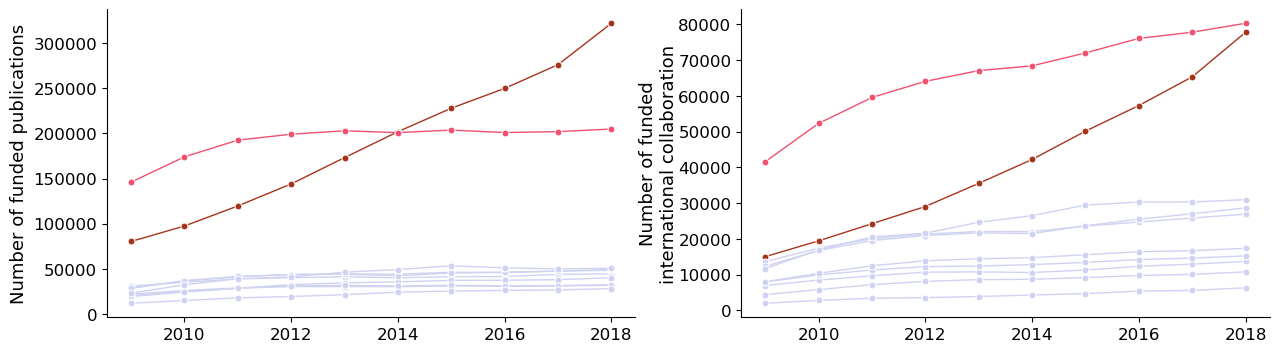

In [85]:
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
ax0=ax[0]
ax1=ax[1]


texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax0, texty, text)
ax0.set_xlabel("")
ax0.set_ylabel("Number of funded publications",fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)


texty=[0.22,0.16,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_coll[topn_coll.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_coll,ax1,texty,text)
ax1.set_xlabel("")
ax1.set_ylabel("Number of funded\ninternational collaboration",fontsize=13,labelpad=0)
ax1.tick_params(axis='both', which='major', labelsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(cntry_funding_pubcnt_path,bbox_inches='tight')